In [1]:
import torch
from torch import nn, triangular_solve
import matplotlib.pyplot as plt
import numpy as np
import os
from os import path
from tqdm import tqdm
import math
from pathlib import Path
from collections import defaultdict
from root import ROOT_DIR
from utils import data_loader_precip, dataset_precip, data_loader_precip, dataset_hybrid
from utils.model_classes import get_model_class
from models import unet_precip_regression_lightning as unet_regr
import glob

node_data = ROOT_DIR / "data" / "precipitation" / "hybrid_train_test_2016-2019_input-length_12_img-ahead_6_rain-threshold_50_size_64.h5"
kriging_data = ROOT_DIR / "data" / "precipitation" / "hybrid_kriging_train_test_2016-2019_input-length_12_img-ahead_6_rain-threshold_50_size_64_64.h5"
epsilon = 1e-6

ALL    = [1,2,3,4,5,6,7,8,9,10,11,12]
WINTER = [12, 1, 2]
SPRING = [3,4,5]
SUMMER = [6,7,8]
AUTUMN = [9, 10, 11]


In [2]:
def get_bin_metrics(model_name, test_dl, thresholds = [0.5, 10, 20], persistence = False, single_input = False, season=ALL):
    
    model_folder = ROOT_DIR / "comparison" / model_name 
    if not persistence:
        model, model_name = get_model_class(model_name)
        models = [m for m in os.listdir(model_folder) if "small" in m]
        model_file = models[0]
        model = model.load_from_checkpoint(f"{model_folder}/{model_file}")
        
    with torch.no_grad():

        cuda = torch.device("cuda")
        if not persistence:
            model.eval()
            model.to(cuda)
        loss_func = nn.functional.mse_loss
        factor = 47.83 #14.98 #factor for denorm
        
        loss_denorm = 0.0

        counts = defaultdict(lambda: defaultdict(int))
        for threshold in thresholds:
            counts[str(threshold)]['total_tp'] = 0
            counts[str(threshold)]['total_fp'] = 0
            counts[str(threshold)]['total_tn'] = 0
            counts[str(threshold)]['total_fn'] = 0

        count = 0
        for input_img, input_2, target_img, target_2, timestamp in tqdm(test_dl, leave=False):
            if timestamp[0].item() not in season: #check if month of first item in batch is in right season
                continue
            x = input_img
            y_true = target_img
            count += 1
            x = x.to(cuda)
            y = input_2.to(cuda)
            y_true = y_true.to(cuda).squeeze()
            y_true = y_true
            
            
            if persistence: ## Override output for persistence model
              y_pred = x[:,-1]
            else:
              if single_input:
                  y_pred = model(x)
              else:
                  y_pred = model(x, y)
            
            y_pred = y_pred.squeeze()
            
            # denormalize
            y_pred_adj = y_pred * factor
            y_true_adj = y_true * factor
            # calculate loss on denormalized data
            loss_denorm += loss_func(y_pred_adj, y_true_adj, reduction="sum")
            
            # convert to mm/h
            y_pred_adj *= 12.0
            y_true_adj *= 12.0
            
            for threshold in thresholds:
                  
              y_pred_mask = y_pred_adj > threshold
              y_true_mask = y_true_adj > threshold
            
              y_pred_mask = y_pred_mask.cpu()
              y_true_mask = y_true_mask.cpu()
            
              tn, fp, fn, tp = np.bincount(y_true_mask.view(-1) * 2 + y_pred_mask.view(-1), minlength=4)
              counts[str(threshold)]['total_tp'] += tp
              counts[str(threshold)]['total_fp'] += fp
              counts[str(threshold)]['total_tn'] += tn
              counts[str(threshold)]['total_fn'] += fn
            
            mse_image = loss_denorm / len(test_dl)
            mse_pixel = mse_image / torch.numel(y_true)
            
    return mse_pixel.item(), mse_image.item(), counts
     

In [3]:
def calculate_mcc(total_tp, total_tn, total_fp, total_fn):
    total_tp = np.array(total_tp, dtype=np.float64)
    total_tn = np.array(total_tn, dtype=np.float64)
    total_fp = np.array(total_fp, dtype=np.float64)
    total_fn = np.array(total_fn, dtype=np.float64)

    numerator = (total_tp * total_tn) - (total_fp * total_fn)
    denominator = np.sqrt((total_tp + total_fp) * (total_tp + total_fn) * (total_tn + total_fp) * (total_tn + total_fn))
    mcc = numerator / denominator if denominator != 0 else 0
    return mcc


In [4]:
def get_metrics(total_tp, total_fp, total_tn, total_fn):
    r = total_tp / (total_tp + total_fn + epsilon)
    p = total_tp / (total_tp + total_fp + epsilon)
    f1 = 2 * p * r / (p + r + epsilon)
    csi = total_tp / (total_tp + total_fn + total_fp + epsilon)
    far = total_fp / (total_tp + total_fp + epsilon)
    hss = (total_tp * total_tn - total_fn * total_fp) / ((total_tp + total_fn) * (total_fn + total_tn) + (total_tp + total_fp) * (total_fp + total_tn) + epsilon)
    mcc = calculate_mcc(total_tp, total_tn, total_fp, total_fn)
    return f1, csi, hss, mcc

In [5]:
def get_dataset(model_name):
    if model_name != "Krige":
        data_file = node_data
    else:
        data_file = kriging_data
    if model_name != "Krige":
        dataset = dataset_hybrid.precipitation_maps_h5_nodes(
            in_file=data_file,
            num_input_images=12,
            num_output_images=6, 
            train=False,
            return_timestamp = True)
    else:
        dataset = dataset_hybrid.precipitation_maps_h5_kriging(
        in_file=data_file,
        num_input_images=12,
        num_output_images=6, 
        train=False,
        return_timestamp = True)

    test_dl = torch.utils.data.DataLoader(
            dataset,
            batch_size=16,
            shuffle=False,
            num_workers=0,
            pin_memory=True
        )
    return test_dl

In [6]:
model_name = "Krige"
dataset = get_dataset(model_name)
_, _, krige_counts_winter = get_bin_metrics(model_name, dataset, season=WINTER)
_, _, krige_counts_spring = get_bin_metrics(model_name, dataset, season=SPRING)
_, _, krige_counts_summer = get_bin_metrics(model_name, dataset, season=SUMMER)
_, _, krige_counts_autumn = get_bin_metrics(model_name, dataset, season=AUTUMN)

In [7]:
model_name = "Smaat"
dataset = get_dataset(model_name)
_, _, smaat_counts_winter = get_bin_metrics(model_name, dataset, single_input=True, season=WINTER)
_, _, smaat_counts_spring = get_bin_metrics(model_name, dataset, single_input=True, season=SPRING)
_, _, smaat_counts_summer = get_bin_metrics(model_name, dataset, single_input=True, season=SUMMER)
_, _, smaat_counts_autumn = get_bin_metrics(model_name, dataset, single_input=True, season=AUTUMN)

In [8]:
model_name = "Bridge"
dataset = get_dataset(model_name)
_, _, bridge_counts_winter = get_bin_metrics(model_name, dataset, season=WINTER)
_, _, bridge_counts_spring = get_bin_metrics(model_name, dataset, season=SPRING)
_, _, bridge_counts_summer = get_bin_metrics(model_name, dataset, season=SUMMER)
_, _, bridge_counts_autumn = get_bin_metrics(model_name, dataset, season=AUTUMN)

In [9]:
model_name = "Persistence"
dataset = get_dataset(model_name)
_, _, persist_counts_winter = get_bin_metrics(model_name, dataset, persistence = True, season=WINTER)
_, _, persist_counts_spring = get_bin_metrics(model_name, dataset, persistence = True, season=SPRING)
_, _, persist_counts_summer = get_bin_metrics(model_name, dataset, persistence = True, season=SUMMER)
_, _, persist_counts_autumn = get_bin_metrics(model_name, dataset, persistence = True, season=AUTUMN)

In [72]:
def plot_results(krige_counts, smaat_counts, bridge_counts, persist_counts, seasons, thresholds=[0.5, 10]):
    input_models = {
        "Persistence": persist_counts,
        "SmaAt-UNet": smaat_counts,
        "SmaAt-fUsion": bridge_counts,
        "SmaAt-Krige-GNet": krige_counts
    }
    metrics_names = ["F1", "CSI", "HSS", "MCC"]
    model_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

    # Iterate through each threshold and each metric
    for threshold in thresholds:
        for metric_idx, metric_name in enumerate(metrics_names):
            plt.figure(figsize=(11, 10))  # Larger figure size for better readability
            
            x = np.arange(len(seasons))  # x positions for seasons
            bar_width = 0.1
            offset = -bar_width  # Initial offset for the first model
            
            # Plot bars for each season and model
            for j, (model_name, counts) in enumerate(input_models.items()):
                metric_values = []
                for season_key in seasons:
                    # Ensure you're accessing the values correctly
                    season_data = counts.get(season_key, {}).get(str(threshold), {})  # Use .get to avoid key errors
                    
                    tp = season_data.get('total_tp', 0)
                    fp = season_data.get('total_fp', 0)
                    tn = season_data.get('total_tn', 0)
                    fn = season_data.get('total_fn', 0)
                    
                    # Ensure the values are numeric (e.g., converting defaultdict values to float)
                    tp, fp, tn, fn = map(float, [tp, fp, tn, fn])
                    
                    # Get metrics for this threshold
                    f1, csi, hss, mcc = get_metrics(tp, fp, tn, fn)
                    metrics_values = [f1, csi, hss, mcc]
                    metric_values.append(metrics_values[metric_idx])  # Append the selected metric value

                # Plot the bars for each season
                plt.bar(
                    x + offset, 
                    metric_values, 
                    width=bar_width, 
                    label=model_name, 
                    color=model_colors[j], 
                    edgecolor='black',  # Add border for visibility
                    linewidth=0.5
                )
                offset += bar_width + 0.02  # Shift position for next model

            # Improve readability with larger fonts and spacing
            plt.title(f"{metric_name} per season ↑", fontsize=22)
            #plt.xlabel("Seasons", fontsize=22, weight='bold')
            plt.ylabel(f"{metric_name}", fontsize=22)
            plt.xticks(x, seasons, fontsize=20)  # Rotate x-ticks slightly for better spacing
            plt.yticks(fontsize=16)
            plt.legend(fontsize=22, title_fontsize=22, loc='upper right')  # Larger text for legend
            plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)  # Add horizontal gridlines for better readability
            plt.ylim(bottom=0, top=1.15)  # Set consistent y-axis range for readability
            #plt.tight_layout()
            filename = f"Plots/{metric_name}_Threshold_{threshold}.png"
            plt.savefig(filename, dpi=300)  # Save plot with high resolution for presentations
            plt.show()


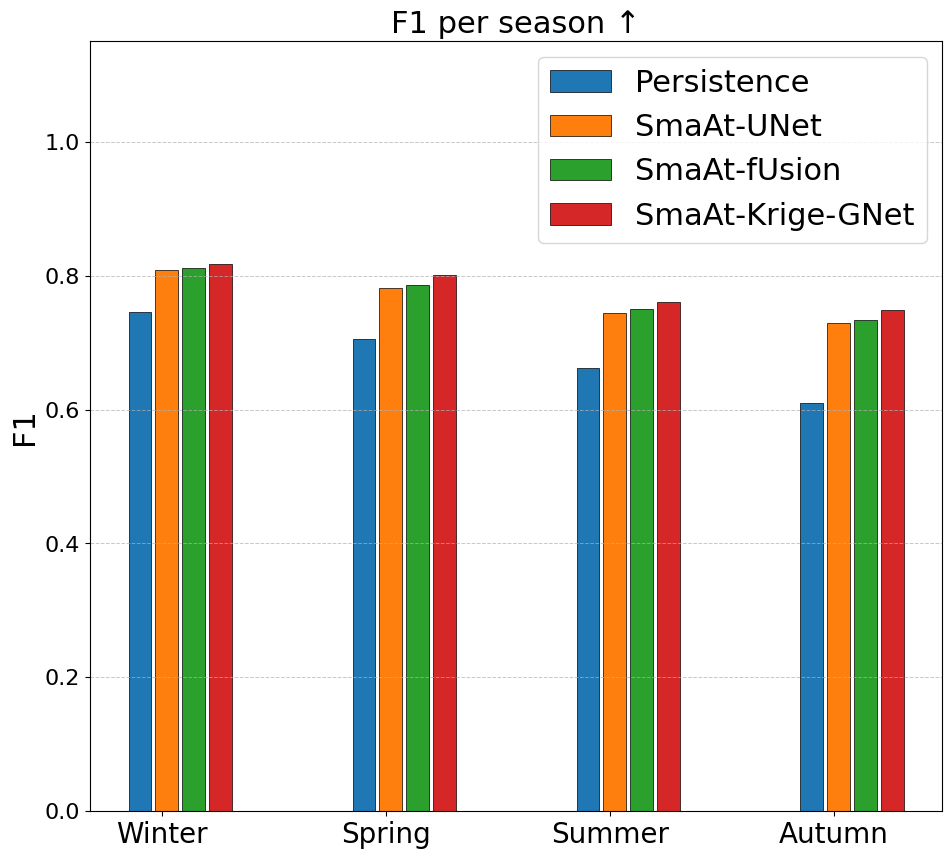

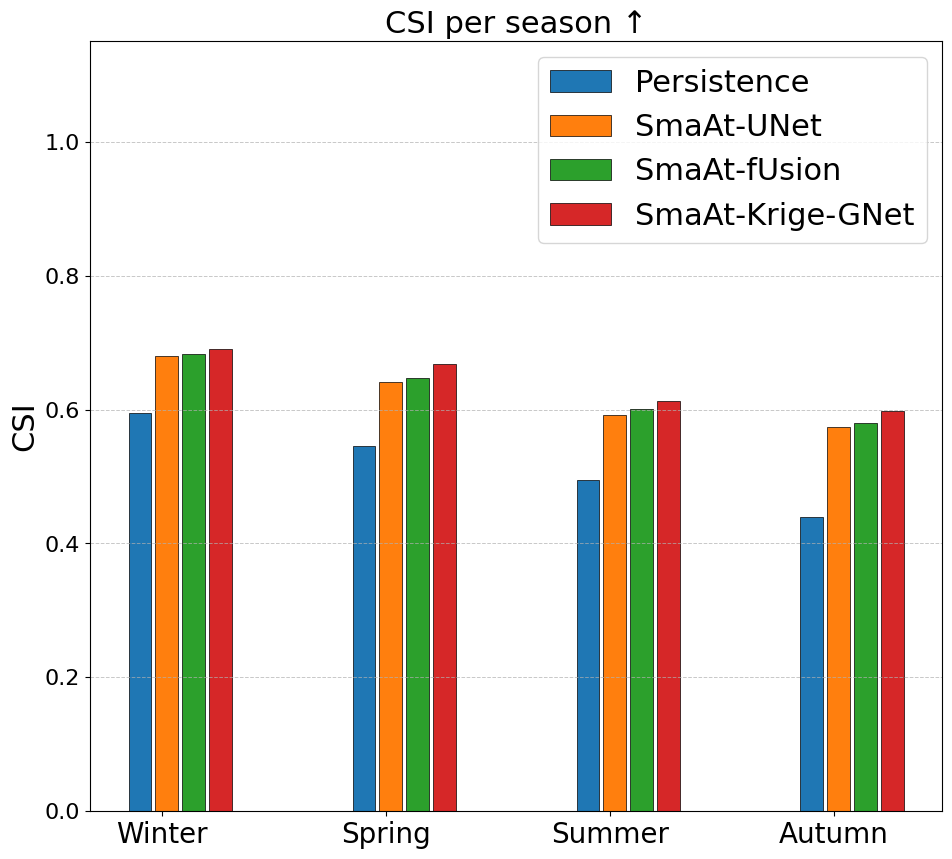

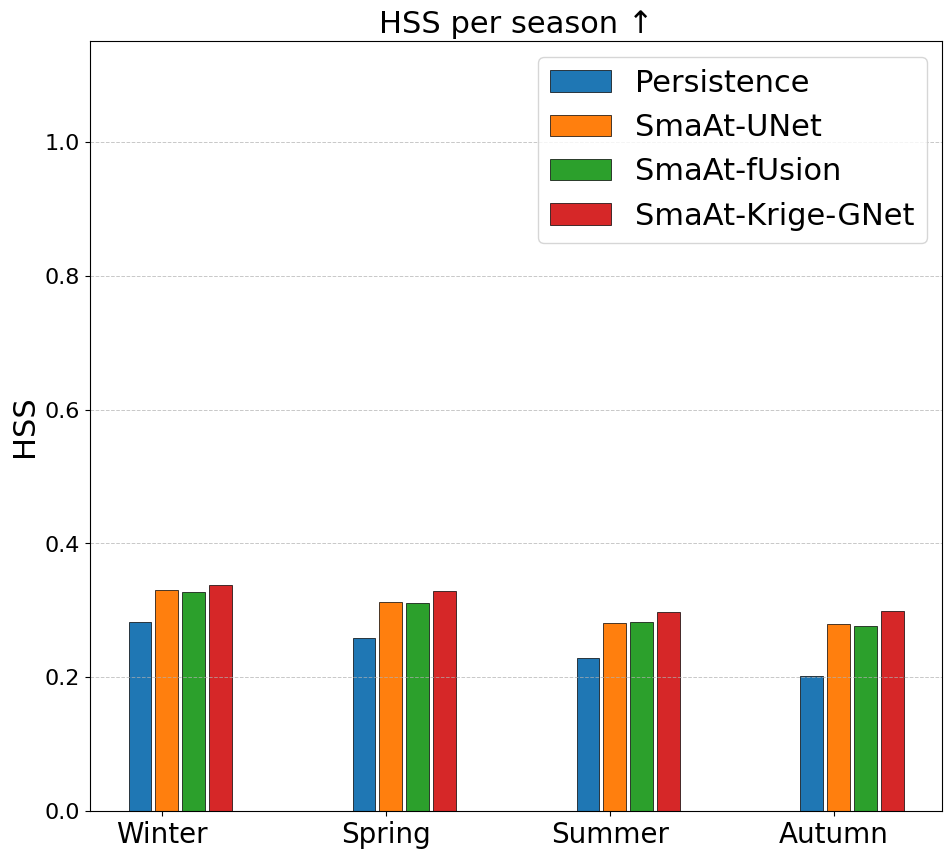

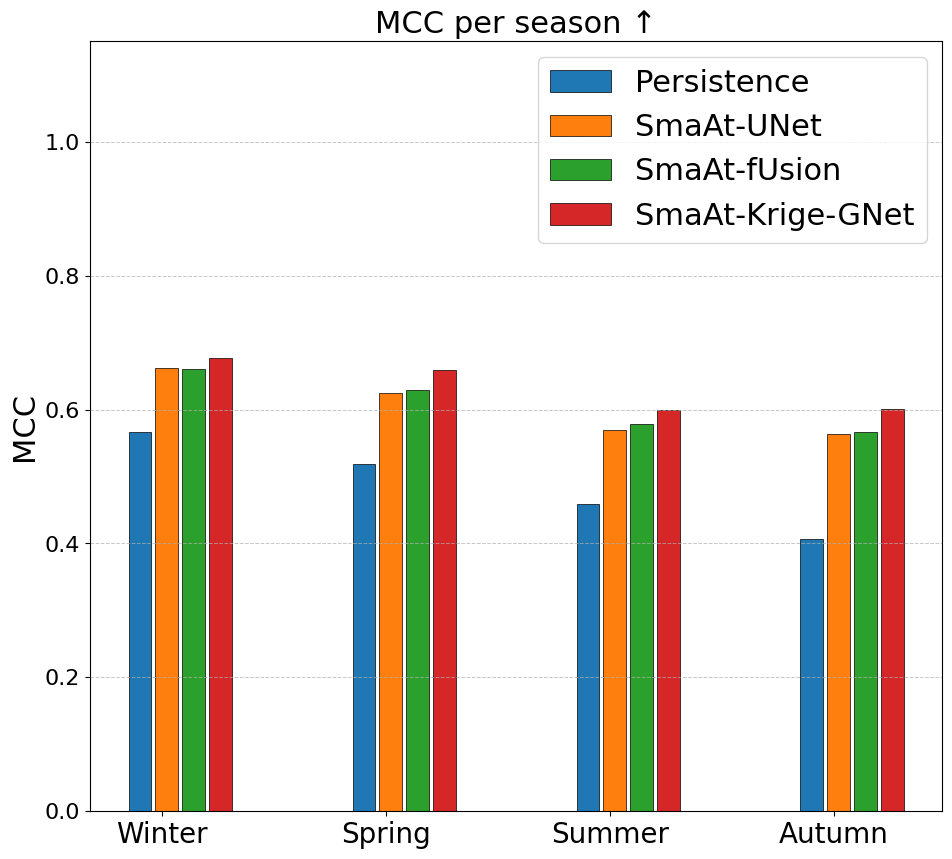

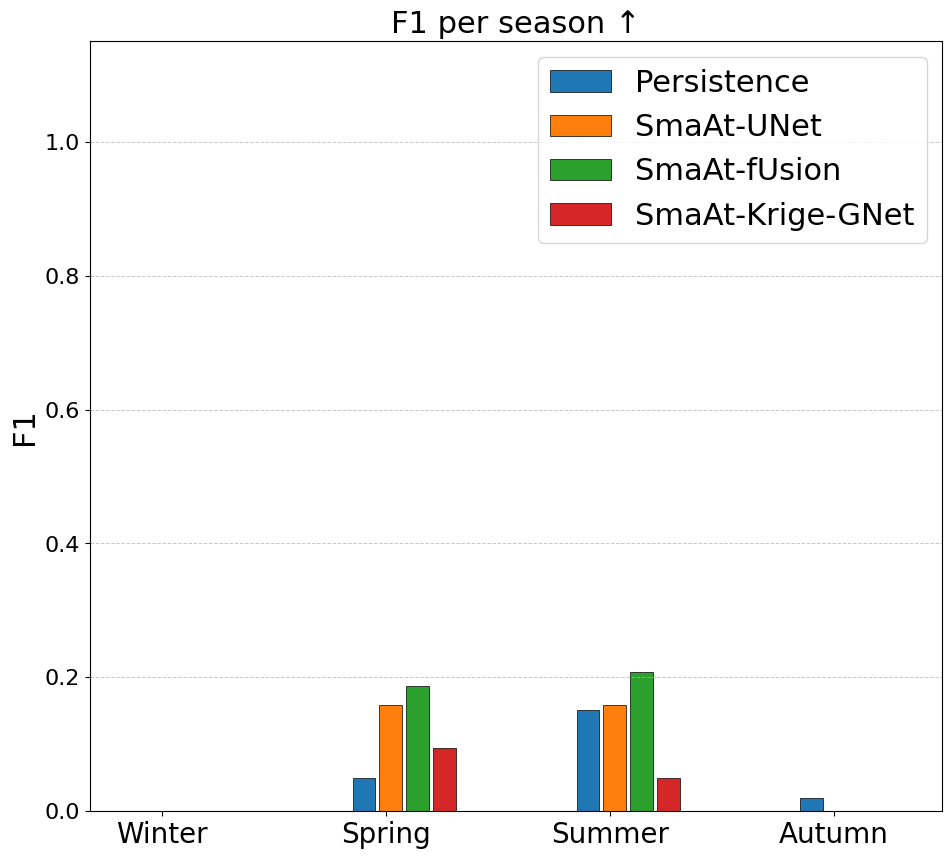

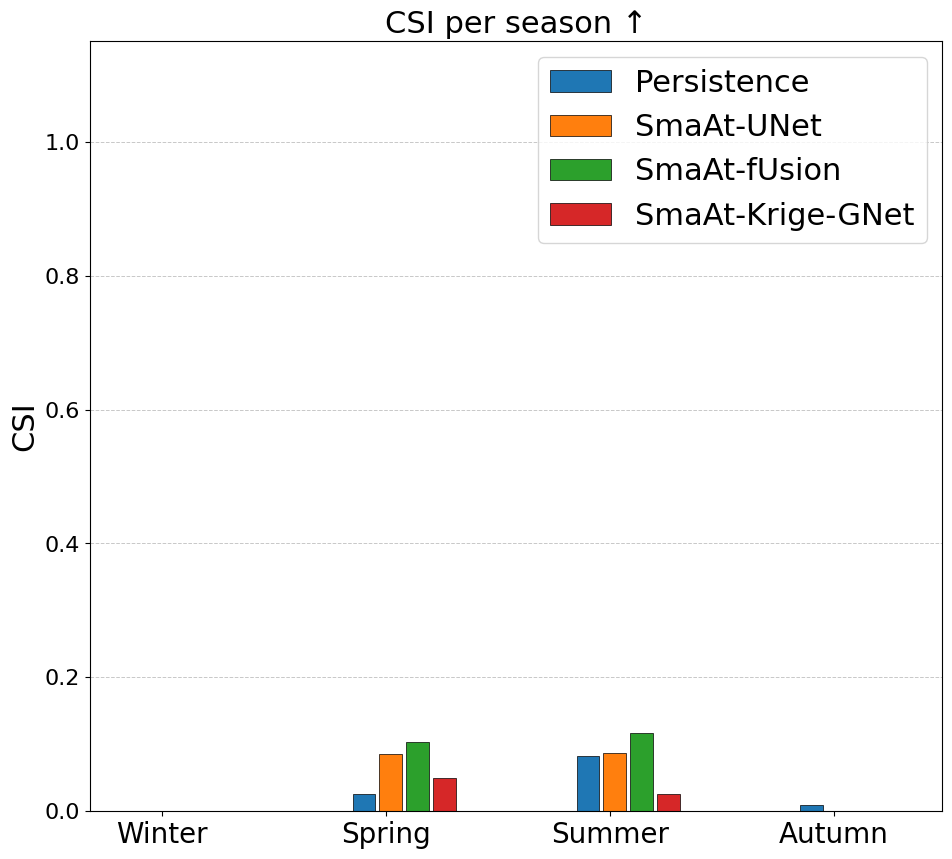

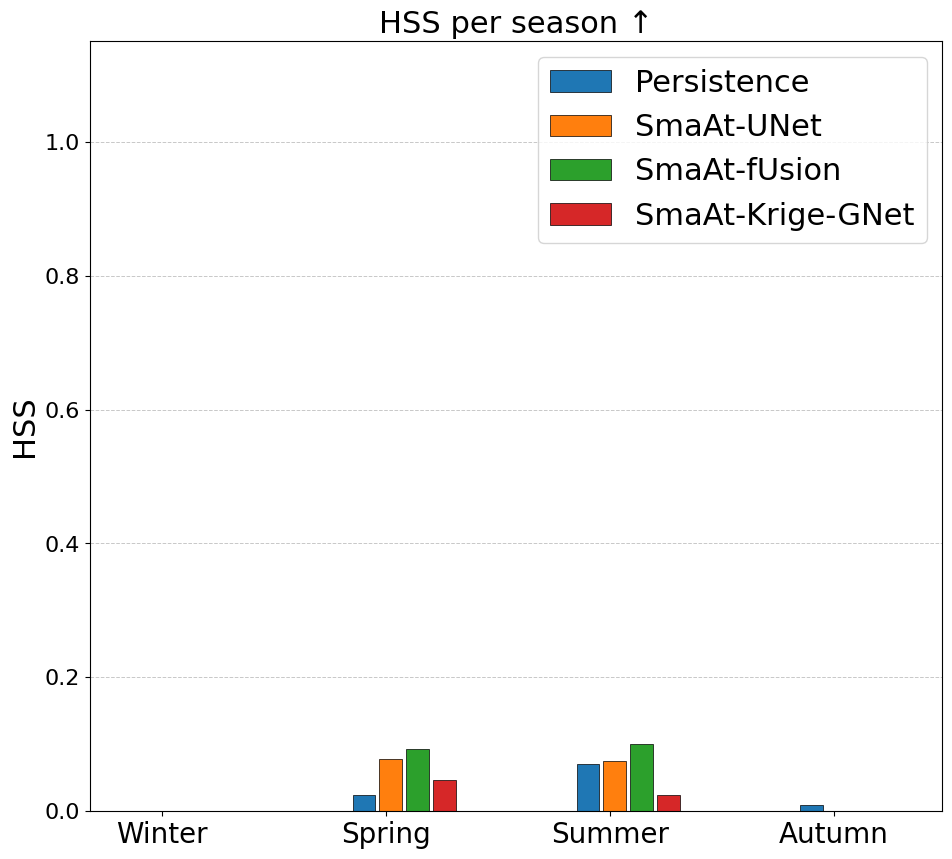

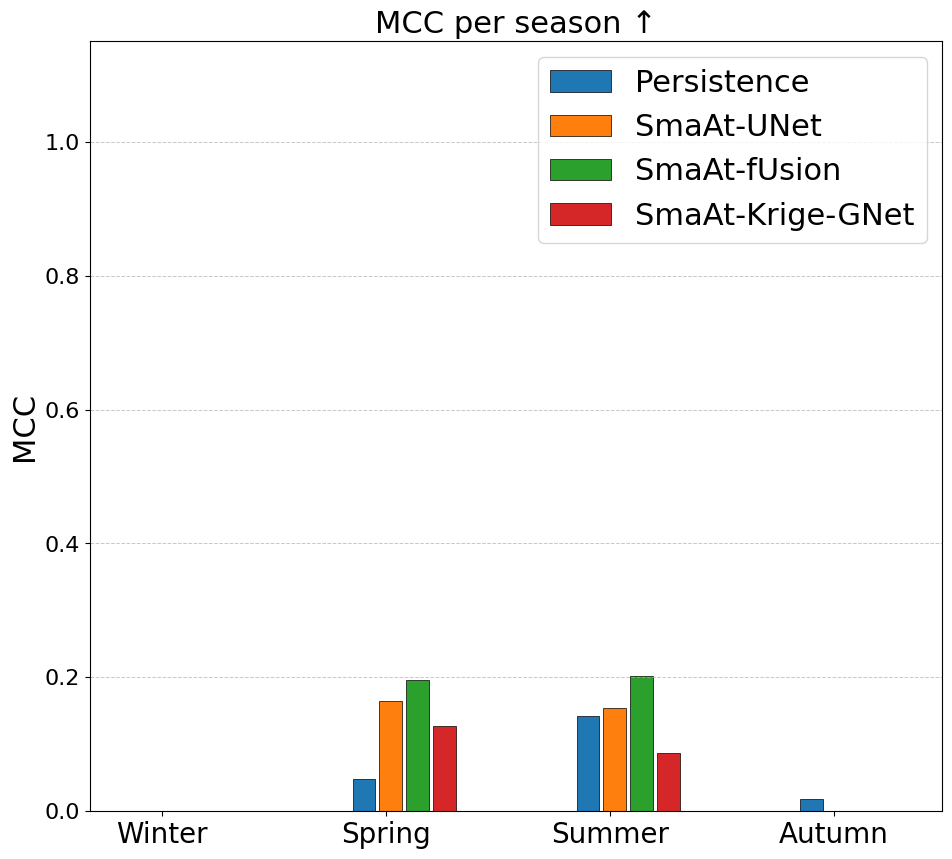

In [73]:
# Example of calling the function
seasons = ["Winter", "Spring", "Summer", "Autumn"]

# Pass the season-specific count variables as a dictionary
plot_results(
    krige_counts={
        "Winter": krige_counts_winter,
        "Spring": krige_counts_spring,
        "Summer": krige_counts_summer,
        "Autumn": krige_counts_autumn
    },
    smaat_counts={
        "Winter": smaat_counts_winter,
        "Spring": smaat_counts_spring,
        "Summer": smaat_counts_summer,
        "Autumn": smaat_counts_autumn
    },
    bridge_counts={
        "Winter": bridge_counts_winter,
        "Spring": bridge_counts_spring,
        "Summer": bridge_counts_summer,
        "Autumn": bridge_counts_autumn
    },  # Bridge counts for each season
    persist_counts={
        "Winter": persist_counts_winter,
        "Spring": persist_counts_spring,
        "Summer": persist_counts_summer,
        "Autumn": persist_counts_autumn
    },  # Persistence counts for each season
    seasons=seasons
)